# Post-Hoc Hypothesis Testing for Feature Selection with Large Volumes of Data Notebook

## About 

## Requirements 

You will need to install the following Python packages to work with this notebook. 

* [Jupyter](https://jupyter.org/)
* [Numpy](http://www.numpy.org/) 
* [Scipy](http://www.scipy.org/) 
* [Matplotlib](http://matplotlib.org/)
* [Sklearn](http://scikit-learn.org/)
* [PyFeast](https://github.com/mutantturkey/PyFeast) 

If there is a package I missed then send an email to <ditzler@email.arizona.edu>.


# Imports

In [1]:
%pylab inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris 
from sklearn.feature_selection import chi2 
from sklearn.feature_selection.univariate_selection import SelectFpr 
from scipy.stats import binom

from fse.feature_selection.ensemble import npfs_chi2
from fse.feature_selection.ensemble import npfs
from fse.feature_selection.ensemble import bootstrap_selection
from fse.feature_selection.single import chi2_selection
from fse.utils import syn_data
from fse.utils import similarities
from fse.experiments import exp_syn_stability

Populating the interactive namespace from numpy and matplotlib


# Iris Example with Noise 

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target
v = np.zeros((4,))

pval, sels = chi2_selection(1.0*X, y, 2)
v[sels] = 1.

print "Fisher Iris Experiment"
print "pval:", pval
print "sels:", sels
print "v:", v

X2 = np.concatenate((X, np.random.rand(150,20)*20), axis =1)
s,b,d = npfs_chi2(X2, y, fpr=0.001, alpha=0.05, n_bootstraps=50)
print len(s), len(X2[1])

# Synthetic Data

## Effect of the polynomial

### Effect of the Polynomial on the Sampling Procedure

In this experiment we measure the effect that the polynomial has on the ability of the bootstrap procedure to detect if a feature is relevant. The polynomial scaling proceedure is implemented as follows. After running NPFS, the Bernoulli R.V.s are normalized to 1 ($p(i)$ for $i \in [K]$) then the effective probability is raised to the $x^{\textrm{th}}$ power. That is

$$
p_{new} (i) = \frac{1}{Z} p^x(i)
$$

where $x \geq 0$ and $Z$ is a normalization constant. We then vary $x$ in the range $[0,5]$ and measure the feature set size that is returned. Clearly as $x$ becomes greater the smaller probabilities will vanish, which will result in fewer features being selected. This result is also compared to not applying the polynomial, which is simply using a normalized version of the counts.


In [19]:
n_averages = 15
n_features = 25
n_observations = 100
n_relevant = 3
polies = [1.*x/10 for x in range(60)]

set_sizes = np.zeros((len(polies),))
no_correction = 0

for pn in range(len(polies)):
    poly = polies[pn]
    for na in range(n_averages):
        data, labels = syn_data(n_features = n_features, n_observations = n_observations, n_relevant = n_relevant)
        sel, binm, delta = npfs_chi2(data, labels, fpr=0.01, alpha=0.01, n_bootstraps=50)
        x1,_ = bootstrap_selection(binm.sum(axis=1), 100, normalizer="poly", poly=poly)
        x2,_ = bootstrap_selection(binm.sum(axis=1), 100, normalizer="minmax")
        set_sizes[pn] += x1
        no_correction += x2

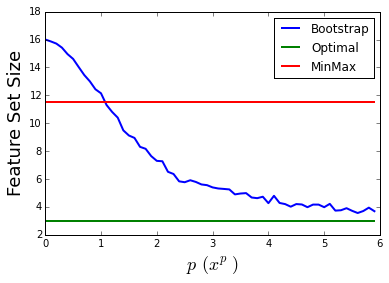

In [20]:
# plot the results from above
axis_font = {'size':'18'}
plt.plot(polies, set_sizes/n_averages, label='Bootstrap', lw=2)
plt.plot(polies, np.ones((len(polies),))*n_relevant, label='Optimal', lw=2)
plt.plot(polies, np.ones((len(polies),))*no_correction/(pn*n_averages), label='MinMax', lw=2)

plt.xlabel('$p\, (x^p)$', **axis_font)
plt.ylabel('Feature Set Size', **axis_font)
plt.legend()
plt.savefig('npfs_feature_size_poly.pdf', bbox_inches='tight')
plt.show()

### Effect of the Polynomial Scaling on a Concieved Problem 

The polynomial that is applied to the probabilities will have a large impact on the bootstrap selection procedure. In this example, we look at the effect that the order of the polynomial will have on the probabilities. 

In [ ]:
axis_font = {'size':'18'}
n = 10
p = np.random.random((n,))
p1 = np.sort(p/p.sum())
p12 = np.sqrt(p1)
p2 = p1**2
p3 = p1**3
p6 = p1**6

p12 = p12/p12.sum()
p2 = p2/p2.sum()
p3 = p3/p3.sum()
p6 = p6/p6.sum()

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True)

ax1.stem(p1)
ax2.stem(p12)
ax3.stem(p2)
ax4.stem(p3)
ax5.stem(p6)

ax1.set_title('$p^1$', **axis_font)
ax2.set_title('$\sqrt{p}$', **axis_font)
ax3.set_title('$p^2$', **axis_font)
ax4.set_title('$p^3$', **axis_font)
ax5.set_title('$p^6$', **axis_font)

ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])
ax4.get_xaxis().set_ticks([])
ax5.get_xaxis().set_ticks([])

plt.savefig('poly_case4.pdf', bbox_inches='tight')
plt.show()

# NPFS' $p_0$

This section of the notebook contains an experiment to examine the Bernoulli matrix in NPFS. Recall that NPFS builds up a matrix of Bernoulli R.V.s and recall that we claim if we examine the sum of the rows scaled by the number of bootstraps that we obtain (approximately) $p_0 = k/K$. We show that this is indeed the case, though we could craft up other possibility for how to view the random variable.

In this experiment, we set $k = 25$, $K=100$, $k^*=5$, and $N=500$. We examine the histgram of $\hat{p}_0$ for each of the features and we do in fact see that $\mathbb{E}[\hat{p}_0] \approx k/K$.

In [ ]:
n_boots, n_feats, n_relev, n_selec, n_averages = 100, 100, 5, 25, 100
axis_font = {'size':'18'}
binz = 10
bino_vec = np.zeros((n_feats,))

for na in range(n_averages):
    bino_mat = np.zeros([n_feats, n_boots])
    for n in range(n_boots):
        x = np.random.permutation(n_feats)
        x = x[:n_selec]
        bino_mat[x[:n_selec], n] = 1.
    bino_vec += bino_mat.sum(axis=1)/n_boots

bino_vec /= n_averages
n, bins, patches = plt.hist(bino_vec, binz)
plt.xlabel('Detections/Bootstraps', **axis_font)
plt.ylabel('Probability', **axis_font)
plt.savefig('npfs_detections.pdf', bbox_inches='tight')
plt.show()

print "Expected Value:", bino_vec.mean()

## Experiment 

In [8]:
exp_syn_stability(fname="stability_a25_K100_n250_r15_b100.pkl", 
                  n_avg=25, 
                  n_feat=100, 
                  n_obs=250, 
                  n_rel=15, 
                  n_boots=50, 
                  fpr=0.05, 
                  alpha=0.1)

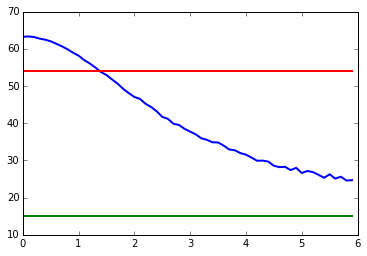

In [21]:
statistics = pickle.load(open("stability_a25_K100_n250_r15_b100.pkl", "rb"))
axis_font = {'size':'18'}
nrel = 15

plt.plot(statistics["polies"], statistics["boot_ss"], label='Bootstrap', lw=2)
plt.plot(statistics["polies"], np.ones((len(statistics["polies"]),))*nrel, label='Optimal', lw=2)
plt.plot(statistics["polies"], np.ones((len(statistics["polies"]),))*statistics["nosc_ss"], label='NPFS', lw=2)
plt.show()

#plt.plot(statistics["polies"], statistics["boot_no"], label='Bootstrap', lw=2)
#plt.plot(statistics["polies"], np.ones((len(statistics["polies"]),))*statistics["npfs_no"], label='NPFS', lw=2)
